In [1]:
%matplotlib inline
from tvb.simulator.lab import *
import os.path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors, cm
import time
import scipy.signal as sig
import scipy.spatial.distance as dists
import numpy as np
import time
from scipy.optimize import fsolve
import os

   INFO  log level set to INFO


WARNING  File 'hemispheres' not found in ZIP.


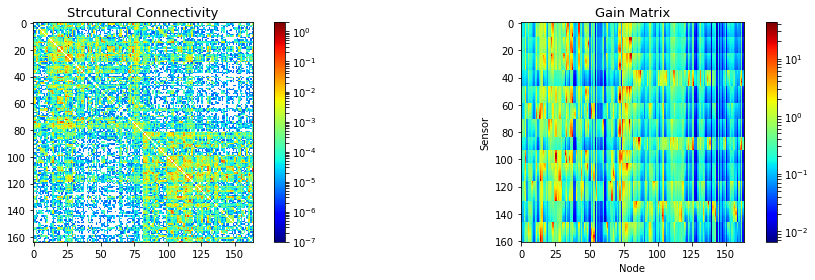

In [2]:
def get_equilibrium(model, init):
    nvars = len(model.state_variables)
    cvars = len(model.cvar)

    def func(x):
        fx = model.dfun(x.reshape((nvars, 1, 1)),
                        np.zeros((cvars, 1, 1)))
        return fx.flatten()

    x = fsolve(func, init)
    return x

root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'datasets/syn_data/id001_bt')
results_dir = os.path.join(root_dir, 'datasets/syn_data/id001_bt_wrng_implnt')
figs_dir = os.path.join(results_dir, 'figures')
! mkdir -p {figs_dir}

# # ROIs chosen for generating synthetic data
# chsnAreas = np.array([27,20,58,18,61])


# ROIs chosen as Epileptogenic/propagation zones
ez = np.array([55,26], dtype=np.int32)
# pz_x0 = np.array([22, 75, 11, 17], dtype=np.int32)
# pz_kplng = [] #np.array([], dtype=np.int32)
# pz = np.append(pz_kplng,pz_x0, dtype=np.int32)
pz = np.array([11, 17, 22, 75], dtype=np.int32)

con = connectivity.Connectivity.from_file(os.path.join(data_dir, "connectivity.destrieux.zip"))
num_regions = len(con.region_labels)

con.speed = np.inf
# normalize
con.weights = con.weights/np.max(con.weights)

# # scaled down the coupling from all nodes to EZ to avoid inhibition due to strong coupling
# wts_sf = 1e-4 # weights scaling factor
# con.weights[ez,:] = wts_sf
# # scale down the coupling from EZ to all nodes except PZ, so seizure is propogated only to PZ
# con.weights[np.ix_(np.setdiff1d(np.r_[0:num_regions],pz),ez)] = wts_sf * con.weights[np.ix_(np.setdiff1d(np.r_[0:num_regions],pz),ez)]
# # scale down the coupling from all nodes (except EZ) to PZ to avoid inhibtion due to strong coupling
# con.weights[np.ix_(pz,np.setxor1d(np.r_[0:num_regions],ez))] = wts_sf * con.weights[np.ix_(pz,np.setxor1d(np.r_[0:num_regions],ez))]
# # scale down the coupling from PZ to all nodes to avoid seizure propagation further
# con.weights[np.ix_(np.setdiff1d(np.r_[0:num_regions],np.append(ez,pz)),pz)] = wts_sf * con.weights[np.ix_(np.setdiff1d(np.r_[0:num_regions],np.append(ez,pz)),pz)]

# con.weights[np.ix_(pz_kplng,ez)] = 4.0
# con.weights[np.ix_(pz_x0,ez)] = 2.0
con.weights[np.ix_(pz,ez)] = 2.0

con.weights[np.diag_indices(con.weights.shape[0])] = 0
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

# Create connectivity object for the chosen ROIs
# conNew = connectivity.Connectivity() 
# conNew.weights = con.weights[:,chsnAreas][chsnAreas,:]
# conNew.tract_lengths = con.tract_lengths[:,chsnAreas][chsnAreas,:]
# conNew.centres = con.centres[chsnAreas]
# conNew.region_labels = np.array([con.region_labels[i] for i in chsnAreas]) 
# conNew.speed = con.speed 
# conNew.cortical = np.ones(len(chsnAreas),dtype=bool)
# num_regions = len(chsnAreas)

gain_mat = np.loadtxt(os.path.join(data_dir,'gain_inv-square.destrieux.txt'))

plt.figure(figsize=[15,4])
plt.subplot(121)
norm = colors.LogNorm(1e-7, con.weights.max())
im = plt.imshow(con.weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=13.0)
plt.subplot(122)
norm = colors.LogNorm(gain_mat.min(), gain_mat.max())
im = plt.imshow(gain_mat,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Gain Matrix', fontsize=13.0)
plt.xlabel('Node')
plt.ylabel('Sensor')
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, 'network.png'))
np.savez(os.path.join(results_dir, 'network.npz'),SC=con.weights,gain_mat=gain_mat)

In [3]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'])
epileptors.r = 1.0/2857
epileptors.Ks = np.ones(num_regions)*(-1)
epileptors.tt = 1
simLen = 5*1000 # simulation length in milliseconds


noiseON = True
epileptors.x0 = np.ones(num_regions)*-3.0

epileptors.x0[ez] = -1.8
epileptors.x0[pz[0]] = -2.5
epileptors.x0[pz[1]] = -2.3
epileptors.x0[pz[2]] = -2.3
epileptors.x0[pz[3]] = -2.5

coupl = coupling.Difference(a=1.)

nsf = 1.0 # noise scaling factor
# hiss = noise.Additive(nsig = nsf*np.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))
hiss = noise.Additive(nsig = nsf*np.array([0.0, 0.0, 0., 0.0, 0.0, 0.]))
if(noiseON):
  heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
else:
  heunint = integrators.HeunDeterministic(dt=0.04)

#mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1.0)
# mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(rootDir, "data/CJ/seeg.txt"),
#                                     projection_fname=os.path.join(rootDir, "data/CJ/gain_inv-square.txt"),
#                                     period=1.0,
#                                     variables_of_interest=[6])
# num_contacts = mon_SEEG.sensors.labels.size



# Find a fixed point to initialize the epileptor in a stable state
epileptor_equil = models.Epileptor()
epileptor_equil.x0 = -3.0
#init_cond = np.array([0, -5, 3, 0, 0, 0])
init_cond = get_equilibrium(epileptor_equil, np.array([0.0, 0.0, 3.0, -1.0, 1.0, 0.0]))
init_cond_reshaped = np.repeat(init_cond, num_regions).reshape((1, len(init_cond), num_regions, 1))
sim = simulator.Simulator(model=epileptors,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,
                          integrator=heunint,
                          monitors=[mon_tavg])

sim.configure()

[(ttavg, tavg)] = sim.run(simulation_length=simLen)
srcSig = tavg[:,0,:,0] + tavg[:,3,:,0]
#  # Normalize the time series for better visualization
# tavgn = (srcSig - np.min(srcSig,1)[:,np.newaxis])/(np.max(srcSig, 1) - np.min(srcSig, 1))[:,np.newaxis]
# Compute the seeg from the source signals
seeg = np.dot(gain_mat,srcSig.T)
# Save data for data fitting
savePathTS=os.path.join(results_dir,"syn_tvb_ez=%s_pz=%s.npz"%('-'.join([str(el) for el in ez]), '-'.join([str(el) for el in pz])))
np.savez(savePathTS, time_steps=ttavg, src_sig=tavg, seeg=seeg, x0=epileptors.x0, Ks=epileptors.Ks, ez=ez, pz=pz)

#### Plot  source activity

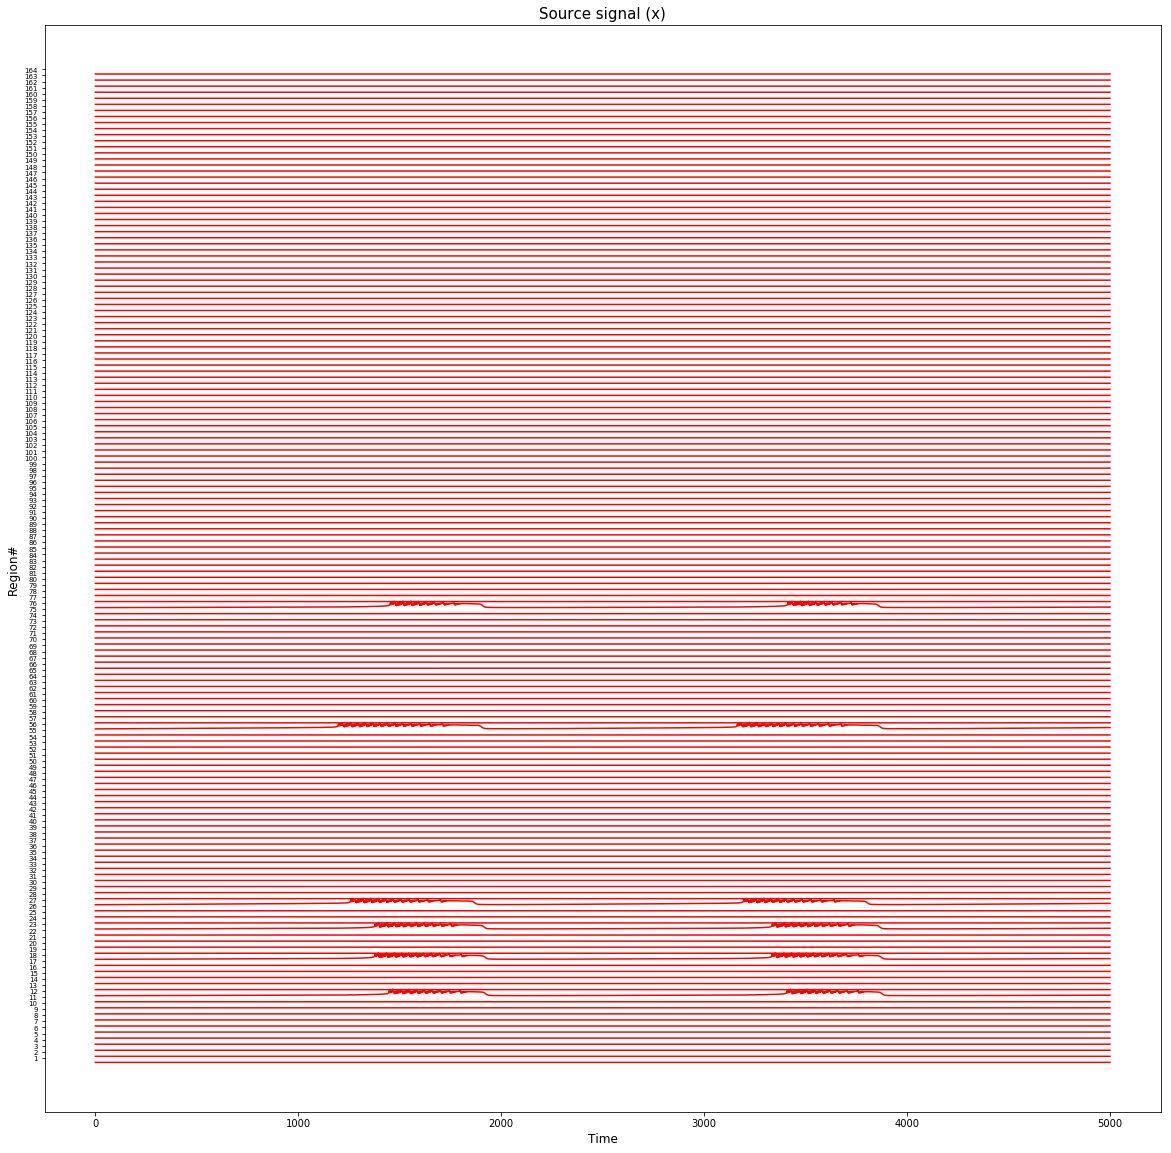

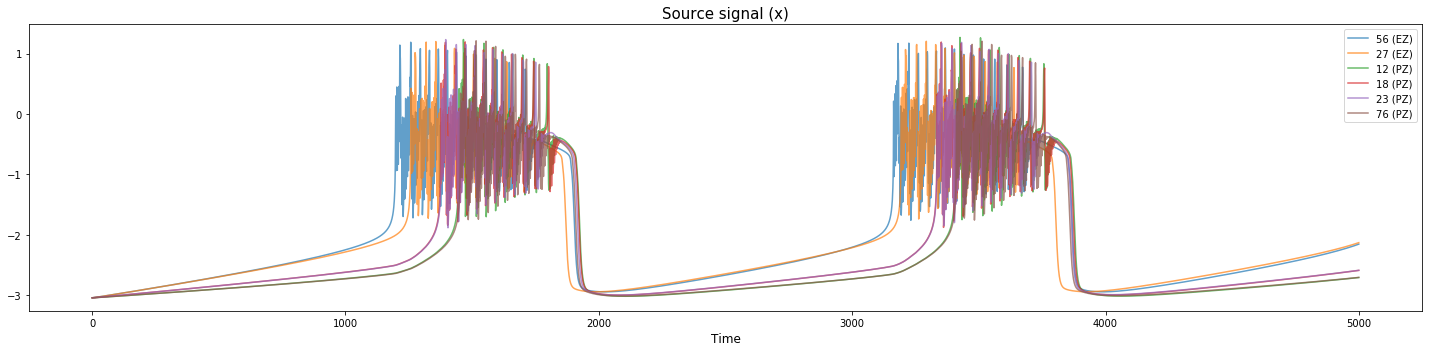

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot source time series
indf = 0
indt = -1

regf = 0
regt = num_regions
plt.figure(figsize=(20,20))
plt.plot(ttavg, srcSig/4 + np.r_[regf:regt], 'r')
plt.yticks(np.r_[regf:regt], np.r_[regf:regt]+1,fontsize=7.0)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(figs_dir, "src_signals_all.png"))

plt.figure(figsize=(20,5))
for roi in ez:
    plt.plot(ttavg, srcSig[:,roi],label=str(roi+1)+' (EZ)',alpha=0.7)
for roi in pz:
    plt.plot(ttavg, srcSig[:,roi],label=str(roi+1)+' (PZ)',alpha=0.7)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "src_signals_seizing_roi.png"))

#### Plot SEEG

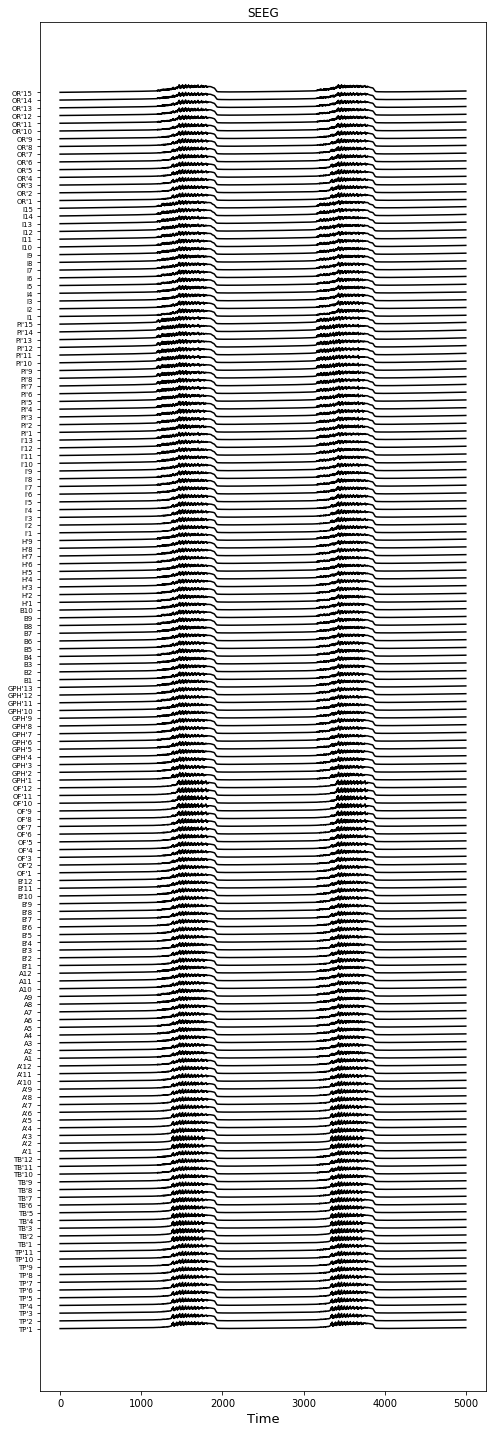

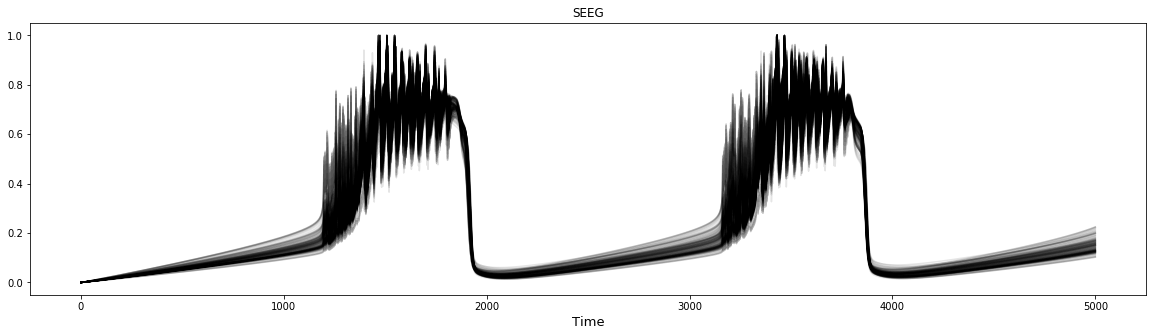

In [5]:
seegn = (seeg - np.min(seeg,1)[:,np.newaxis]) / (np.max(seeg,1) - np.min(seeg,1))[:,np.newaxis]
#  seegn = seegn - np.mean(seegn)
#  b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#  seegf = sig.filtfilt(B, A, seegn)
#  seegf = np.zeros(seegn.shape)
#  for i in range(num_contacts):
#      seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])


# Plot the seeg time series
nChannels = np.shape(gain_mat)[0]
with open(os.path.join(data_dir,'seeg.xyz'),'r') as fd:
    snsrLabels = [line.split(' ')[0] for line in fd]

plt.figure(figsize=(7,20))
plt.plot(ttavg, seegn.T + np.r_[0:nChannels],'k')
plt.xlabel('Time',fontsize=13.0)
plt.yticks(np.r_[0:nChannels], snsrLabels, fontsize=7.0)
plt.title("SEEG")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir,"seeg_split.png"))

plt.figure(figsize=(20,5));
plt.plot(ttavg, seegn.T, 'k', alpha=0.1);
plt.xlabel('Time',fontsize=13.0)
plt.title('SEEG')

plt.savefig(os.path.join(figs_dir,"seeg_overlap.png"))